## 如何制作自己的图数据

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch

#### 创建一个图，信息如下：

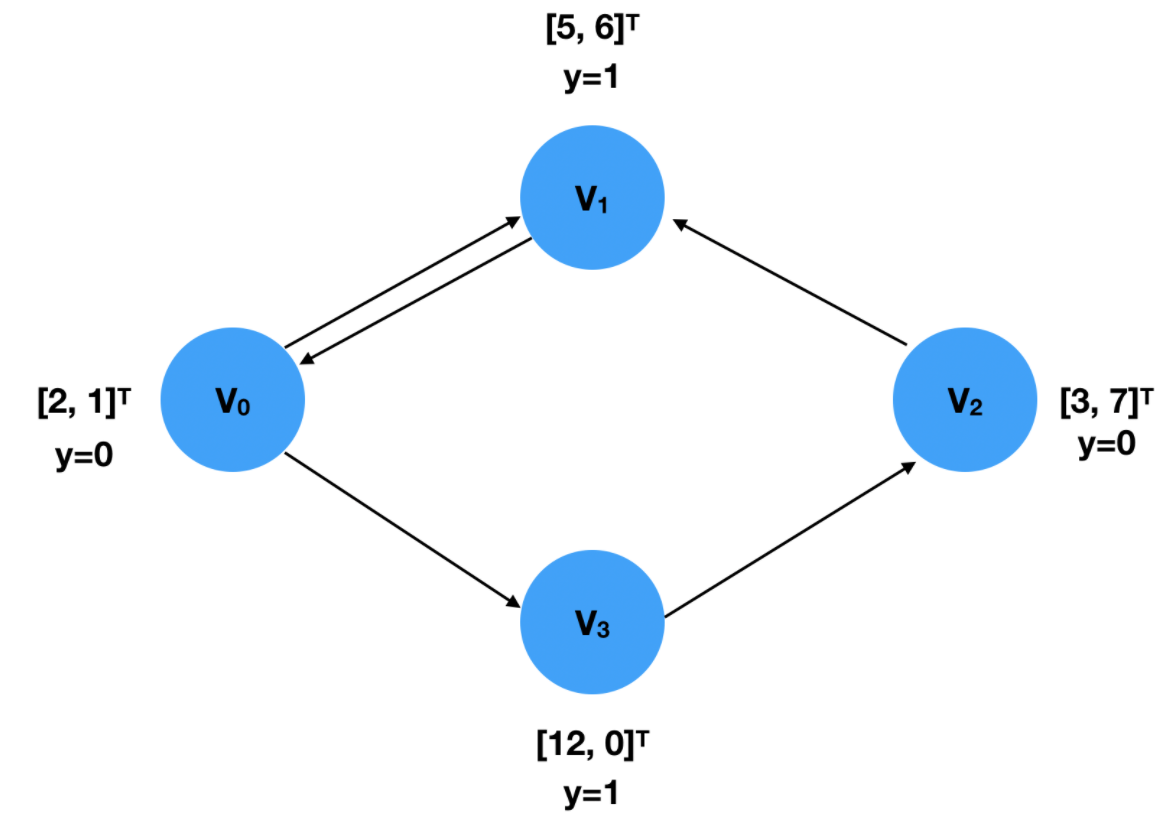

x是每个点的输入特征，y是每个点的标签

In [2]:
x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

In [3]:
edge_index = torch.tensor([[0, 1, 2, 0, 3],  # 起始点
                           [1, 0, 1, 3, 2]], dtype=torch.long)  # 终止点

边的顺序定义无所谓的，上下两种是一样的

In [4]:
edge_index = torch.tensor([[0, 2, 1, 0, 3],
                           [3, 1, 0, 1, 2]], dtype=torch.long)

创建torch_geometric中的图

In [6]:
from torch_geometric.data import Data

x = torch.tensor([[2, 1], [5, 6], [3, 7], [12, 0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

edge_index = torch.tensor([[0, 2, 1, 0, 3],
                           [3, 1, 0, 1, 2]], dtype=torch.long)

data = Data(x=x, y=y, edge_index=edge_index)

In [7]:
data

Data(x=[4, 2], edge_index=[2, 5], y=[4])

## 故事是这样的
- 在很久很久以前，有一群哥们在淘宝一顿逛，最后可能买了一些商品
- yoochoose-clicks：表示用户的浏览行为，其中一个session_id就表示一次登录都浏览了啥东西
- item_id就是他所浏览的商品，其中yoochoose-buys描述了他最终是否购会买点啥呢，也就是咱们的标签

In [9]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = pd.read_csv('./datasets/yoochoose-clicks.dat', header=None)
df.columns = ['session_id', 'timestamp', 'item_id', 'category']

buy_df = pd.read_csv('./datasets/yoochoose-buys.dat', header=None)
buy_df.columns = ['session_id', 'timestamp', 'item_id', 'price', 'quantity']

item_encoder = LabelEncoder()
df['item_id'] = item_encoder.fit_transform(df.item_id)
df.head()

session_id                 timestamp  item_id category
0           1  2014-04-07T10:51:09.277Z     2053        0
1           1  2014-04-07T10:54:09.868Z     2052        0
2           1  2014-04-07T10:54:46.998Z     2054        0
3           1  2014-04-07T10:57:00.306Z     9876        0
4           2  2014-04-07T13:56:37.614Z    19448        0

In [10]:
import numpy as np
#数据有点多，咱们只选择其中一小部分来建模
sampled_session_id = np.random.choice(df.session_id.unique(), 100000, replace=False)
df = df.loc[df.session_id.isin(sampled_session_id)]
df.nunique()

session_id    100000
timestamp     354996
item_id        20432
category         121
dtype: int64

把标签也拿到手

In [11]:
df['label'] = df.session_id.isin(buy_df.session_id)
df.head()

session_id                 timestamp  item_id category  label
487         144  2014-04-01T15:53:23.538Z    39906        0  False
488         144  2014-04-01T15:53:58.913Z    29357        0  False
489         144  2014-04-01T15:54:20.576Z    39907        0  False
490         144  2014-04-01T15:56:48.595Z    12936        0  False
491         144  2014-04-01T15:58:29.643Z     3777        0  False

In [12]:
df.shape

(355008, 5)

### 接下来我们制作数据集
- 咱们把每一个session_id都当作一个图,每一个图具有多个点和一个标签
- 其中每个图中的点就是其item_id，特征咱们暂且用其id来表示，之后会做embedding

#### 数据集制作流程
- 1.首先遍历数据中每一组session_id，目的是将其制作成(from torch_geometric.data import Data)格式
- 2.对每一组session_id中的所有item_id进行编码(例如15453,3651,15452)就按照数值大小编码成(2,0,1)
- 3.这样编码的目的是制作edge_index，因为在edge_index中我们需要从0，1，2，3.。。开始
- 4.点的特征就由其ID组成，edge_index是这样，因为咱们浏览的过程中是有顺序的比如(0,0,2,1)
- 5.所以边就是0->0,0->2,2->1这样的，对应的索引就为target_nodes: [0 2 1]，source_nodes: [0 0 2]
- 6.最后转换格式data = Data(x=x, edge_index=edge_index, y=y)
- 7.最后将数据集保存下来（以后就不用重复处理了）

这部分代码就把中间过程打印出来，方便同学们理解

In [13]:
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
df_test = df[:100]
grouped = df_test.groupby('session_id')
for session_id, group in tqdm(grouped):
    print('session_id:', session_id)
    sess_item_id = LabelEncoder().fit_transform(group.item_id)
    print('sess_item_id:', sess_item_id)
    group = group.reset_index(drop=True)
    group['sess_item_id'] = sess_item_id
    print('group:', group)
    node_features = group.loc[group.session_id == session_id, [
        'sess_item_id', 'item_id']].sort_values('sess_item_id').item_id.drop_duplicates().values
    node_features = torch.LongTensor(node_features).unsqueeze(1)
    print('node_features:', node_features)
    target_nodes = group.sess_item_id.values[1:]
    source_nodes = group.sess_item_id.values[:-1]
    print('target_nodes:', target_nodes)
    print('source_nodes:', source_nodes)
    edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
    x = node_features
    y = torch.FloatTensor([group.label.values[0]])
    data = Data(x=x, edge_index=edge_index, y=y)
    print('data:', data)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 333.23it/s]

session_id: 144
sess_item_id: [5 4 6 3 2 1 0 1]
group:    session_id                 timestamp  item_id category  label  sess_item_id
0         144  2014-04-01T15:53:23.538Z    39906        0  False             5
1         144  2014-04-01T15:53:58.913Z    29357        0  False             4
2         144  2014-04-01T15:54:20.576Z    39907        0  False             6
3         144  2014-04-01T15:56:48.595Z    12936        0  False             3
4         144  2014-04-01T15:58:29.643Z     3777        0  False             2
5         144  2014-04-01T15:59:47.926Z     3761        0  False             1
6         144  2014-04-01T16:01:08.181Z     3757        0  False             0
7         144  2014-04-01T16:01:42.146Z     3761        0  False             1
node_features: tensor([[ 3757],
        [ 3761],
        [ 3777],
        [12936],
        [29357],
        [39906],
        [39907]])
target_nodes: [4 6 3 2 1 0 1]
source_nodes: [5 4 6 3 2 1 0]
data: Data(x=[7, 1], edge_index=[2, 7],

In [14]:
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm


class YooChooseBinaryDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(YooChooseBinaryDataset, self).__init__(
            root, transform, pre_transform)  # transform就是数据增强，对每一个数据都执行
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):  # 检查self.raw_dir目录下是否存在raw_file_names()属性方法返回的每个文件
        # 如有文件不存在，则调用download()方法执行原始文件下载
        return []

    @property
    # 检查self.processed_dir目录下是否存在self.processed_file_names属性方法返回的所有文件，没有就会走process
    def processed_file_names(self):
        return ['yoochoose_click_binary_1M_sess.dataset']

    def download(self):
        pass

    def process(self):

        data_list = []

        # process by session_id
        grouped = df.groupby('session_id')
        for session_id, group in tqdm(grouped):
            sess_item_id = LabelEncoder().fit_transform(group.item_id)
            group = group.reset_index(drop=True)
            group['sess_item_id'] = sess_item_id
            node_features = group.loc[group.session_id == session_id, [
                'sess_item_id', 'item_id']].sort_values('sess_item_id').item_id.drop_duplicates().values

            node_features = torch.LongTensor(node_features).unsqueeze(1)
            target_nodes = group.sess_item_id.values[1:]
            source_nodes = group.sess_item_id.values[:-1]

            edge_index = torch.tensor(
                [source_nodes, target_nodes], dtype=torch.long)
            x = node_features

            y = torch.FloatTensor([group.label.values[0]])

            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [15]:
dataset = YooChooseBinaryDataset(root='data/')

## API文档解释如下：
- https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.pool.TopKPooling

### TopKPooling流程
- 其实就是对图进行剪枝操作，选择分低的节点剔除掉，然后再重新组合成一个新的图

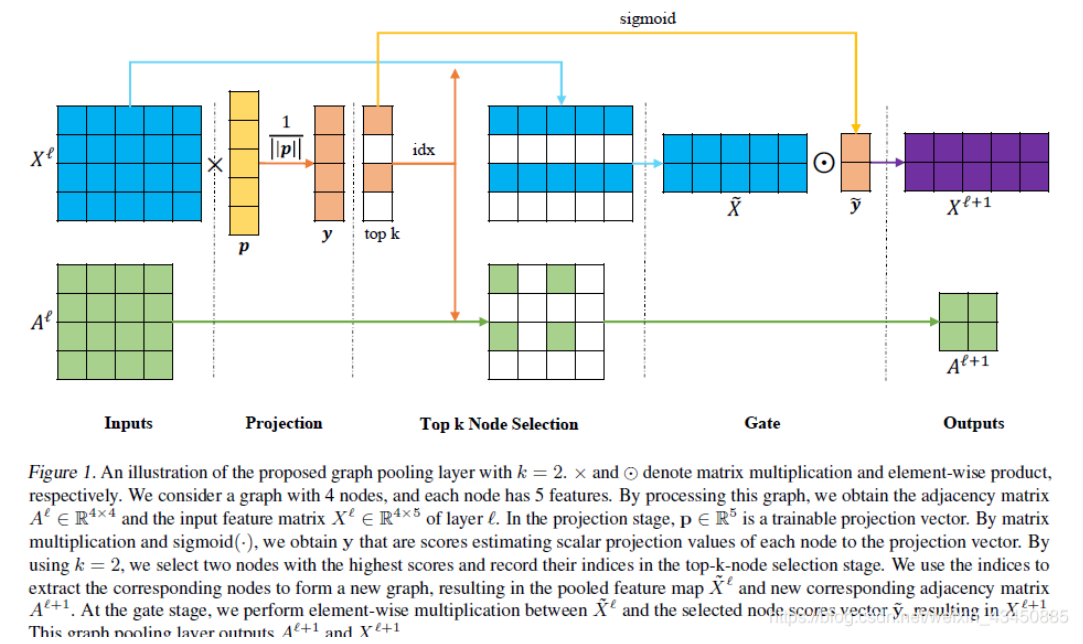

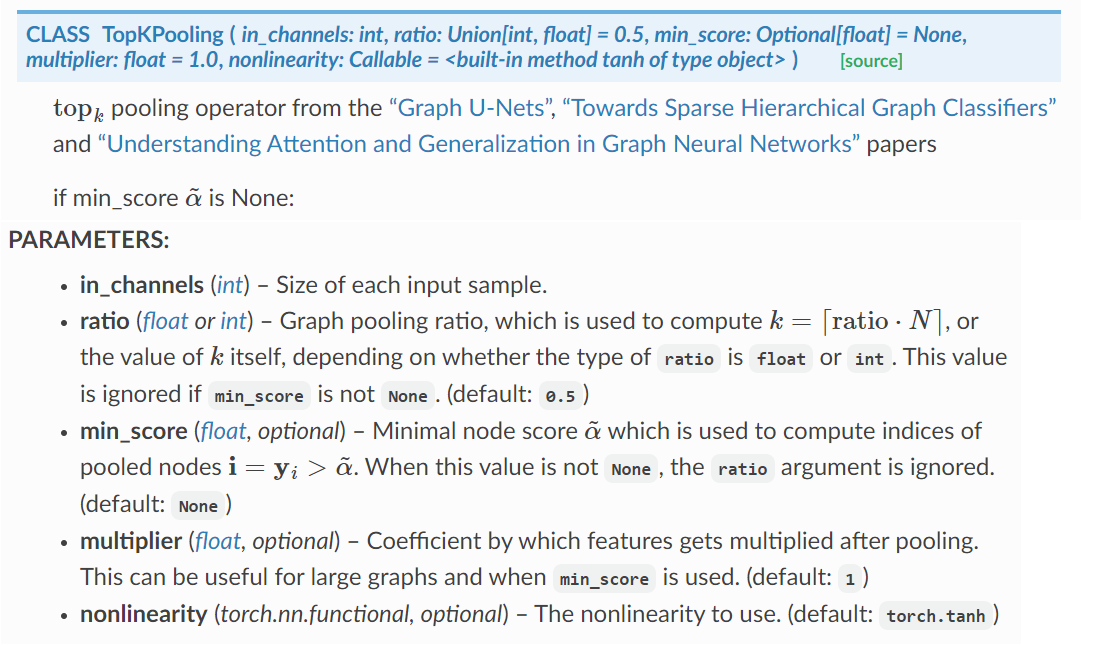

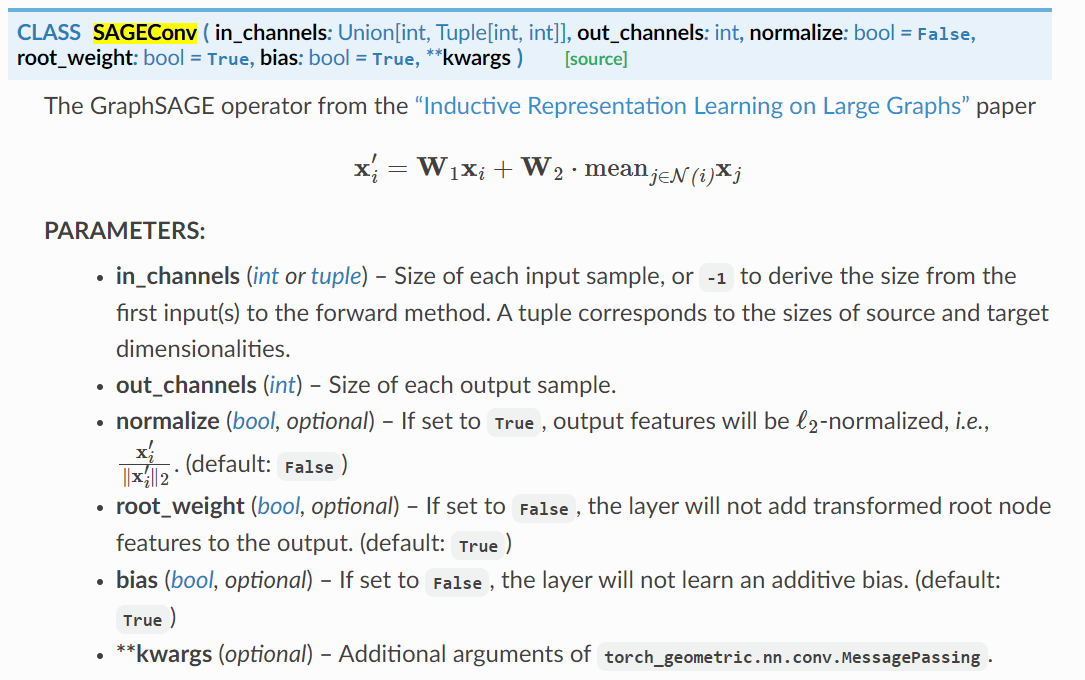

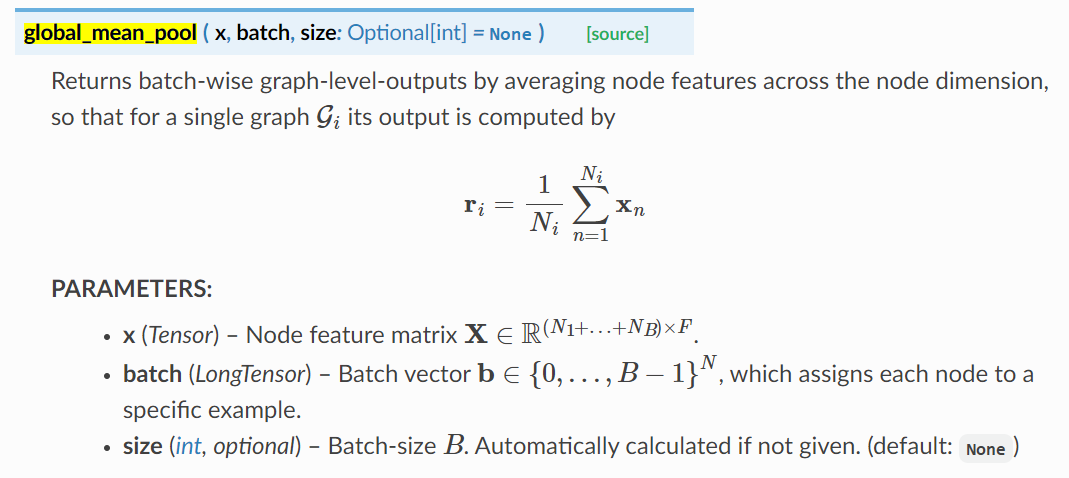

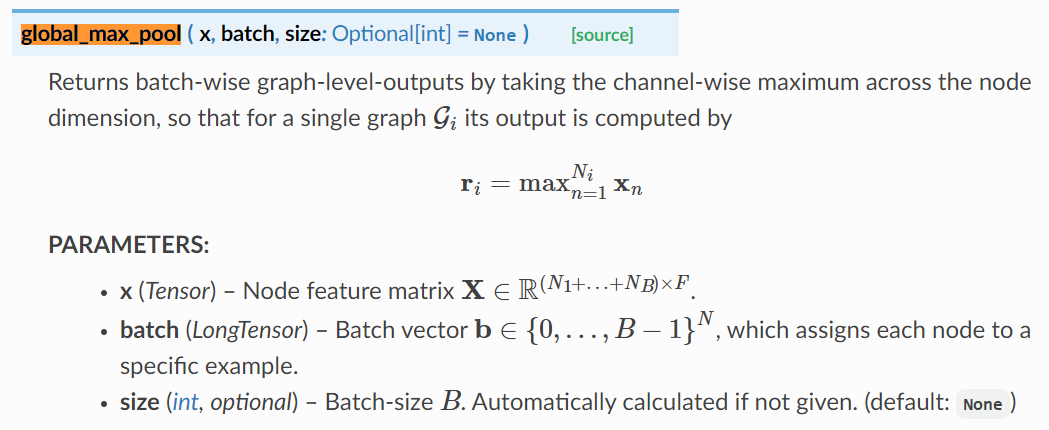

### 构建网络模型
- 模型可以任选，这里只是举例而已
- 跟咱们图像中的卷积和池化操作非常类似，最后再全连接输出

In [27]:
from torch_geometric.nn import TopKPooling, SAGEConv
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embed_dim = 128


class Net(torch.nn.Module):  # 针对图进行分类任务
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = SAGEConv(embed_dim, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = SAGEConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = SAGEConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)
        self.item_embedding = torch.nn.Embedding(
            num_embeddings=df.item_id.max() + 10, embedding_dim=embed_dim)
        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch  # x:n*1,其中每个图里点的个数是不同的
        # print(x)
        x = self.item_embedding(x)  # n*1*128 特征编码后的结果
        # print('item_embedding',x.shape)
        x = x.squeeze(1)  # n*128
        # print('squeeze',x.shape)
        x = F.relu(self.conv1(x, edge_index))  # n*128
        # print('conv1',x.shape)
        x, edge_index, _, batch, _, _ = self.pool1(
            x, edge_index, None, batch)  # pool之后得到 n*0.8个点
        # print('self.pool1',x.shape)
        # print('self.pool1',edge_index)
        # print('self.pool1',batch)
        # x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        x1 = gap(x, batch)
        # print('gmp',gmp(x, batch).shape) # batch*128
        # print('cat',x1.shape) # batch*256
        x = F.relu(self.conv2(x, edge_index))
        # print('conv2',x.shape)
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        # print('pool2',x.shape)
        # print('pool2',edge_index)
        # print('pool2',batch)
        # x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        x2 = gap(x, batch)
        # print('x2',x2.shape)
        x = F.relu(self.conv3(x, edge_index))
        # print('conv3',x.shape)
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        # print('pool3',x.shape)
        # x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        x3 = gap(x, batch)
        # print('x3',x3.shape)# batch * 256
        x = x1 + x2 + x3  # 获取不同尺度的全局特征

        x = self.lin1(x)
        # print('lin1',x.shape)
        x = self.act1(x)
        x = self.lin2(x)
        # print('lin2',x.shape)
        x = self.act2(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.sigmoid(self.lin3(x)).squeeze(1)  # batch个结果
        # print('sigmoid',x.shape)
        return x

In [28]:
from torch_geometric.loader import DataLoader


def train():
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data
        # print('data',data)
        optimizer.zero_grad()
        output = model(data)
        label = data.y
        loss = crit(output, label)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(dataset)


model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
crit = torch.nn.BCELoss()
train_loader = DataLoader(dataset, batch_size=64)
for epoch in range(10):
    print('epoch:', epoch)
    loss = train()
    print(loss)

epoch: 0
0.21383523407101632
epoch: 1
0.1923125632107258
epoch: 2
0.17628825497269632
epoch: 3
0.15730181092619896
epoch: 4
0.1406132375997305
epoch: 5
0.12482743380367756
epoch: 6
0.11302556532740593
epoch: 7
0.1032185257422924
epoch: 8
0.09486922759741545
epoch: 9
0.09064080653965473


In [29]:
from sklearn.metrics import roc_auc_score


def evalute(loader, model):
    model.eval()

    prediction = []
    labels = []

    with torch.no_grad():
        for data in loader:
            data = data  # .to(device)
            pred = model(data)  # .detach().cpu().numpy()

            label = data.y  # .detach().cpu().numpy()
            prediction.append(pred)
            labels.append(label)
    prediction = np.hstack(prediction)
    labels = np.hstack(labels)

    return roc_auc_score(labels, prediction)

In [30]:
for epoch in range(1):
    roc_auc_score = evalute(dataset,model)
    print('roc_auc_score',roc_auc_score)

roc_auc_score 0.9325659815540558
